# VGG16 Model

In [1]:
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [2]:
vgg16 = VGG16()

In [3]:
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [ ]:
vgg16_weights = vgg16.get_weights()

In [ ]:
print(type(vgg16_weights), len(vgg16_weights))

In [ ]:
print(len(vgg16.layers))

In [ ]:
for layer in vgg16_weights:
    print(len(layer))

# VOC2012 Segmentation Data

In [3]:
import skimage.io as io
import numpy as np

In [ ]:
img = io.imread('VOC2012/SegmentationClass/2007_000032.png')
print(type(img), img.shape)
io.imshow(img)
io.show()

mask = np.ndarray((281, 500))

for i in range(len(img)):
    for j in range(len(img[0])):
        if img[i][j].any() != 0:
            mask[i][j] = 1
        else:
            mask[i][j] = 0

io.imshow(mask)
io.show()

# FCN32

In [1]:
from models.fcn32 import FCN32

Using TensorFlow backend.


In [2]:
fcn32 = FCN32()

In [6]:
fcn32.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [ ]:
fcn32_weights = fcn32.get_weights()
print(len(fcn32_weights))

for layer in fcn32_weights:
    print(len(layer))

In [ ]:
def set_weights(fcn, vgg):
    for i in range(18):
        fcn.layers[i].set_weights(vgg.layers[i+1].get_weights())

set_weights(fcn32, vgg16)

In [ ]:
from utils.loss import cross_entropy_logits
from utils.metric import logits_accuracy

In [ ]:
def logits_loss(y_true, y_pred):
    return sum([y_true[i][j]^y_pred[i][j] for i in range(224) for j in range(224)])

def logits_accuracy(y_true, y_pred):
    return 1 - logits_loss(y_true, y_pred)/(224.0*224.0)

In [ ]:
from keras import optimizers

In [ ]:
adam = optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
fcn32.compile(loss=logits_loss,
              optimizer=adam,
              metrics=[logits_accuracy])

# Prediction Demo

In [ ]:
from skimage.transform import resize
from keras import backend as K

img = io.imread('VOC2012/JPEGImages/2007_000032.jpg')
#io.imshow(img)
#io.show()
img =resize(img, (224, 224, 3))
img = np.expand_dims(img, 0)
pred = fcn32.predict(img, batch_size=1)
print(type(pred), pred.shape)

pred = np.argmax(pred, axis=3)
pred = np.squeeze(pred)
print(type(pred), pred.shape)

io.imshow(pred)
io.show()

# VOC Segmentation Data

In [ ]:
import numpy as np
import glob
import skimage.io as io
import os.path
import tensorflow as tf

In [ ]:
def seg_to_img(seg, img_path):
    # convert an image file path into a corresponding mask file path 
    dirname, basename = os.path.split(seg)
    imgname = basename.replace(".png", ".jpg")
    return os.path.join(img_path, imgname)

In [ ]:
segs = [seg for seg in glob.glob("VOC2012/SegmentationClass/*")]
pairs = [(seg_to_img(seg, "VOC2012/JPEGImages/"), seg) for seg in segs]
print("number of image segmentation pairs: ", len(pairs))

In [ ]:
def seg_to_mask(img):
    mask = np.ndarray((224, 224))
    for i in range(len(img)):
        for j in range(len(img[0])):
            if img[i][j].any() != 0:
                mask[i][j] = 1
            else:
                mask[i][j] = 0
    return mask

In [ ]:
def generate_data():
    seg_names = [seg for seg in glob.glob("VOC2012/SegmentationClass/*")]
    img_names = [seg_to_img(seg, "VOC2012/JPEGImages/") for seg in seg_names]
    imgs = np.ndarray((2913, 224, 224, 3))
    masks = np.ndarray((2913, 224, 224))
    for i in range(2913):
        seg =resize(io.imread(seg_names[i]), (224, 224, 3))
        masks[i] = seg_to_mask(seg)
        img = resize(io.imread(img_names[i]), (224, 224, 3))
        imgs[i] = img
    return imgs, masks

imgs, masks = generate_data()

In [ ]:
np.save("imgs.npy", imgs)
np.save("masks.npy", masks)

In [ ]:
print(type(imgs), imgs.shape)
print(type(masks), masks.shape)

In [ ]:
new_masks = np.ndarray((2913, 224, 224, 1))

for i in range(2913):
    new_masks[i] = np.expand_dims(masks[i], -1)

In [ ]:
print(type(new_masks), new_masks.shape)

# Train FCN32

In [ ]:
# run on gpu0
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
fcn32_history = fcn32.fit(imgs, new_masks, 
          batch_size=32, 
          epochs=5,
          verbose=1,
          validation_split=0.2)

In [ ]:
# Save model and weights

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'fcn32.h5'


if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
fcn32.save(model_path)
print('Saved trained model at %s ' % model_path)

In [ ]:
# Score trained model.
scores = fcn32.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [ ]:
print(type(fcn32_history))

# FCN32 Prediction

In [4]:
fcn32.load_weights("saved_models/fcn32_tmp.h5")

/home/charlioxumykj/miniconda3/envs/dlnd/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


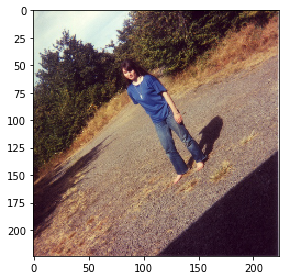

/home/charlioxumykj/miniconda3/envs/dlnd/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


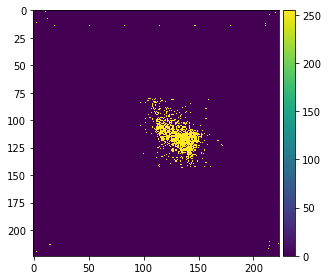

In [7]:
from utils.prediction import predict

mask = predict(fcn32, "VOCdevkit/VOC2012/JPEGImages/2007_000027.jpg")